In [66]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

p_edge = 1
K = 5

def graph(G):
    lambda_2 = 1
    C = nx.to_numpy_array(G)
    K = C.shape[0] 
    while lambda_2 > 0.99999999:
        # C = np.eye(K)
        # for k in range(K):
        #     for l in range(k+1, K):
        #         connected = np.random.binomial(1, p_edge) # 1 if connected, 0 otherwise probability of 1 is p_edge
        #         if connected == 1:
        #             C[l, k] = 1
        #             C[k, l] = 1

        # C is an undericted graph
        # in my example I should have a parameter on how many edges I want to have
    

    # mult C by Kx1 matrix to create a sum of the rows on the diagnonal giving a Kx1 matrix
        n = C @ np.ones((K,))
        
        # Follow Metrolpolis formula
        A = np.zeros((K, K))
        for k in range(K):
            for l in range(k+1, K):
                if C[k, l] == 1:
                    A[k, l] = np.true_divide(1, np.max([n[k], n[l]]))
                    A[l, k] = A[k, l]

        degrees = A @ np.ones((K,))
        for k in range(K):
            A[k, k] = 1 - degrees[k]
        
        eigs = np.linalg.eigvalsh(A)
        lambda_2 = eigs[-2]

    return A



C Graph with 5 nodes and 6 edges
C:  [[0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0.]]
3.0
2.0
3.0
3.0
3.0
3.0
0.8333333333333333
1.0
0.8333333333333333
0.6666666666666666
1.0
A [[0.16666667 0.33333333 0.5        0.         0.        ]
 [0.33333333 0.         0.         0.33333333 0.33333333]
 [0.5        0.         0.16666667 0.         0.33333333]
 [0.         0.33333333 0.         0.33333333 0.33333333]
 [0.         0.33333333 0.33333333 0.33333333 0.        ]]


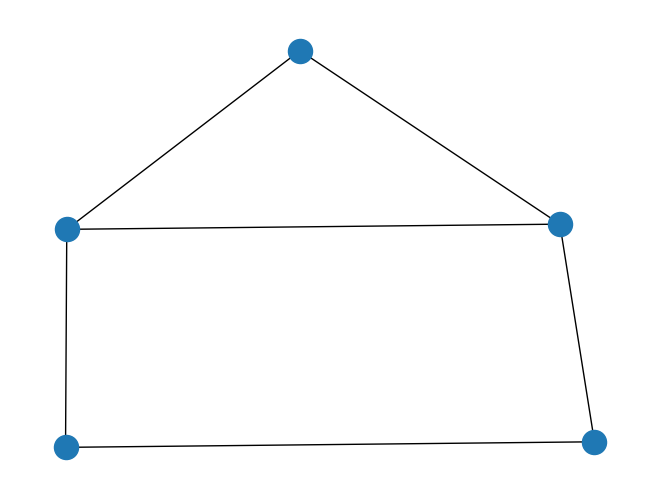

In [90]:


def generate_erdos_renyi_graph(num_users, edge_prob):
     return nx.erdos_renyi_graph(n=num_users, p=edge_prob)


def generate_mixing_matrix(communication_graph):
    K = len(communication_graph.nodes)
    A = torch.zeros((K, K))
    for i in communication_graph.nodes:
        for j in communication_graph.nodes:
            if i != j and (i, j) in communication_graph.edges:
                A[i, j] = 1.0 / max(communication_graph.degree[i], communication_graph.degree[j])

    for i in range(K):
        A[i, i] = 1 - A[i].sum()

    return A

def construct_metropolis_combination_matrix(G):
    """Constructs the Metropolis rule combination matrix from a NetworkX graph."""
    # Convert graph to adjacency matrix as a numpy array
    C = nx.to_numpy_array(G)

    K = C.shape[0]  # Number of nodes
    n = C @ np.ones((K,))
    
    # Initialize the combination matrix A with zeros
    A = np.zeros((K, K))
    
    # Compute off-diagonal elements according to Metropolis rule
    for k in range(K):
        for l in range(k + 1, K):  # Only upper triangle needed due to symmetry
            if C[k, l] == 1:
                A[k, l] = np.true_divide(1, np.max([n[k], n[l]]))
                print(np.max([n[k], n[l]]))
                A[l, k] = A[k, l]

    
    # Compute diagonal elements to make rows sum to 1
    degrees = A @ np.ones((K,))
    for k in range(K):
        A[k, k] = 1 - degrees[k]
        print(degrees[k])

    return A

C = generate_erdos_renyi_graph(5, 0.5)
print("C", C)
# A = graph(C)
A = construct_metropolis_combination_matrix(C)
print("A", A)
nx.draw(C)
# nx.draw(A)

# print(A)


#### Things To Do

* Implement basic multi agent-in a graph setting
* U
* Check out Vlaski work on Exact diffusion
    * https://github.com/MultiAgentOptimizationAndLearning/labs/blob/main/Lab_2_Decentralized_Learning.ipynb
    
    * Incorporate exact diffusion to the model


### Project Plan 
* **Erdos-Renyi model -**   that is a G(n, M) model: A graph of n vertices is constructed, and exactly M edges are added to the graph choosing at random from all possible edges.
    * The goal is to see what effect the reduction of nubmer of edges does to the accuracy and robustness of the model
    * In the case where M = n the model results should be the same as federated case

* **Exact Diffusion** in the case of non-IID data performs considerably better


#### Federated SimCLR code structure

Federated SimCLR

    1. First load dataset CIFAR10 - get_dataset
    2. Distribute the dataset IID among agents - cifar_iid
    3. Every agent makes a copy of the global model

    1. TRAINING GLOBAL ROUNDS/EPOCHS
        1. If specified select how many local models updated by frac
        2. UPDATE LOCAL MODELS
            1. Get each local model from local_update_clients(idx) 
            2. Find the weight and loss of local model from update_ssl_weights
                1. Run local epoch
                    1. run local batches
                    2. Use the given global model to run the local data through it to update the local model
                    3. Return weights and the average loss
            3. Get global weights by averaging the weights of local models
            4. Update local models with the new global model
    2. CLASSIFIER TRAINING
        1. Tain a linear classifier using the learnt representations
        2. Use global_repr_global_classifier()
        3. We use ResnetCifarClassifier to see how well the trained model is performing 